# Objective
    1) Remove test images without defect from Step1
    2) Remove train images without defect (Only use the train images with defect(s) for training)
    2) Predict Mask

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

# df_test
## Remove test images without defect from Step1

In [2]:
test = pd.read_csv('./output/submission_step1.csv')
test['EncodedPixels_1'] = np.nan
test['EncodedPixels_2'] = np.nan
test['EncodedPixels_3'] = np.nan
test['EncodedPixels_4'] = np.nan

print("test.shape:", test.shape)
test.head()

test.shape: (1801, 6)


,ImageId,defect,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4
0,004f40c73.jpg,True,NaN,NaN,NaN,NaN
1,006f39c41.jpg,True,NaN,NaN,NaN,NaN
2,00b7fb703.jpg,False,NaN,NaN,NaN,NaN
3,00bbcd9af.jpg,True,NaN,NaN,NaN,NaN
4,0108ce457.jpg,False,NaN,NaN,NaN,NaN


In [3]:
test1 = test[test['defect']==True]    #predict
test0 = test[test['defect']==False]   #done

print('test1.shape:', test1.shape)
print('test0.shape:', test0.shape)

test1.shape: (1115, 6)
test0.shape: (686, 6)


In [4]:
# test3 = pd.concat([test1 ,test0], axis=0)
# test3 = test3.sort_index()

# print("test3.shape:", test3.shape)
# test3.head()

# df_train

In [5]:
raw_train = pd.read_csv('./input/train.csv')
print("raw_train.shape:", raw_train.shape)
raw_train.head()

raw_train.shape: (50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


## 1) Split into ImageId, ClassId

In [6]:
raw_train['ImageId'] = raw_train['ImageId_ClassId'].str[:-2]
raw_train['ClassId'] = raw_train['ImageId_ClassId'].str[-1:]
raw_train['defect'] = raw_train['EncodedPixels'].notnull()

raw_train = raw_train[['ImageId','ClassId','defect','EncodedPixels']]

In [7]:
print('{} = no. of train_images * 4'.format(raw_train.shape[0]))
print('raw_train.shape:', raw_train.shape)
raw_train.head()

50272 = no. of train_images * 4
raw_train.shape: (50272, 4)


,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


## 2) Remove train images without defect
    Only use the train images with defect(s) for training

In [8]:
train = raw_train[raw_train['defect']==True].reset_index(drop=True)

print('There are {} masks in total'.format(train.shape[0]))
print('train.shape:', train.shape)
train.head()

There are 7095 masks in total
train.shape: (7095, 4)


,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...


3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64


Text(0, 0.5, 'No. of images')

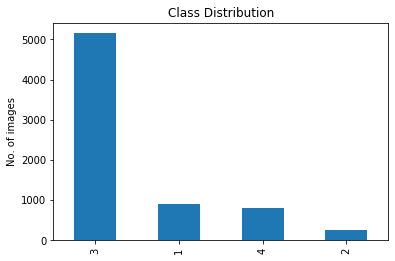

In [9]:
print(train['ClassId'].value_counts())   # for checking

train['ClassId'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("No. of images")

# Split train into y_train, y_val 

In [10]:
VALIDATION_SPLIT = 0.1

In [11]:
from sklearn.model_selection import train_test_split

y_train, y_val = train_test_split(train, test_size=VALIDATION_SPLIT, random_state=63)

In [12]:
print('y_train.shape:', y_train.shape)
y_train.head()

y_train.shape: (6385, 4)


,ImageId,ClassId,defect,EncodedPixels
1323,3035a46b7.jpg,3,True,160179 1 160433 4 160687 7 160942 10 161196 13...
6598,ed8d0e78c.jpg,3,True,257793 128 258049 255 258305 255 258561 255 25...
1607,3ade75b6e.jpg,3,True,2933 1 3187 3 3441 6 3695 8 3949 11 4203 13 44...
4208,99224c3d5.jpg,4,True,271371 2 271626 7 271880 13 272135 18 272390 2...
4495,a41f575ff.jpg,3,True,53505 32 53761 96 54017 160 54273 224 54529 48...


3    4644
1     803
4     718
2     220
Name: ClassId, dtype: int64
Ratio: 0.034456


Text(0, 0.5, 'No. of images')

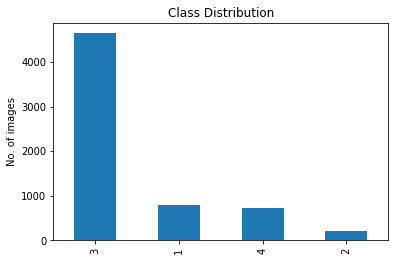

In [13]:
print(y_train['ClassId'].value_counts())   # for checking
print('Ratio: {:f}'.format(y_train['ClassId'].value_counts()[3]/y_train['ClassId'].value_counts().sum()))

y_train['ClassId'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("No. of images")

In [14]:
print('y_val.shape:', y_val.shape)
y_val.head()

y_val.shape: (710, 4)


,ImageId,ClassId,defect,EncodedPixels
1050,25f9a8622.jpg,4,True,171 10 408 30 646 48 883 68 1129 78 1385 79 16...
4771,ad6fb4fab.jpg,3,True,344835 127 345091 254 345347 254 345603 254 34...
5611,ca02e9e92.jpg,3,True,249025 64 249153 6592 352982 43 353153 128 353...
1253,2dd290c91.jpg,3,True,281593 8 281834 23 282076 37 282317 52 282558 ...
2663,62b0a31ba.jpg,3,True,266721 32 266913 96 267105 160 267297 23754 29...


3    506
1     94
4     83
2     27
Name: ClassId, dtype: int64
Ratio: 0.038028


Text(0, 0.5, 'No. of images')

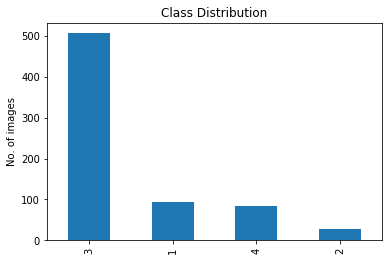

In [15]:
print(y_val['ClassId'].value_counts())   # for checking
print('Ratio: {:f}'.format(y_val['ClassId'].value_counts()[3]/y_val['ClassId'].value_counts().sum()))

y_val['ClassId'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("No. of images")

# 1) Train Data Generator

In [16]:
BATCH_SIZE = 8

In [44]:
def train_datagen(batch_size):
    
    count = 0
    
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            print(str(y_train['ImageId'].iloc[i]))
            img = cv2.imread( './input/train_images/'+str(y_train['ImageId'].iloc[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            #print(str(y_train['EncodedPixels'].iloc[i]).split(' ')[0]+'\n')
            mask = rle2mask(y_train['EncodedPixels'].iloc[i])
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            img = img/255.0
            mask = mask/255.0
            
            x_batch += [img]       # x_batch.append(img)
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [45]:
for i in range(3):
    batch_x, batch_y = next(train_datagen(4))

'''Problem: same batch'''

3035a46b7.jpg
ed8d0e78c.jpg
3ade75b6e.jpg
99224c3d5.jpg
3035a46b7.jpg
ed8d0e78c.jpg
3ade75b6e.jpg
99224c3d5.jpg
3035a46b7.jpg
ed8d0e78c.jpg
3ade75b6e.jpg
99224c3d5.jpg


3035a46b7.jpg
ed8d0e78c.jpg
3ade75b6e.jpg
99224c3d5.jpg
a41f575ff.jpg
847b7640a.jpg
44668f045.jpg
6ed69f517.jpg
(8, 256, 256, 3) (8, 256, 256, 1)


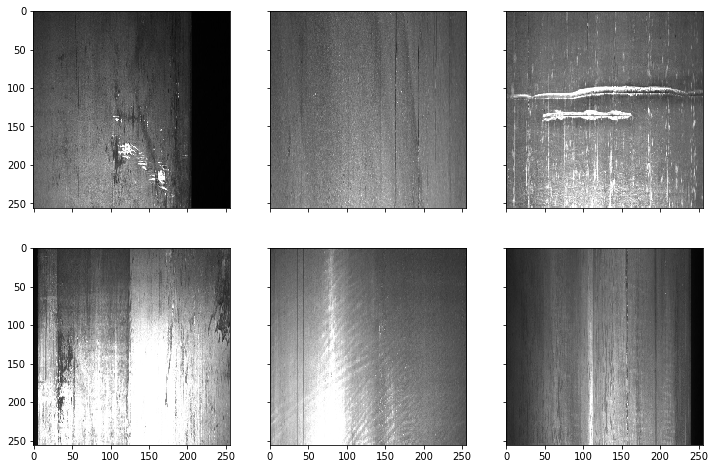

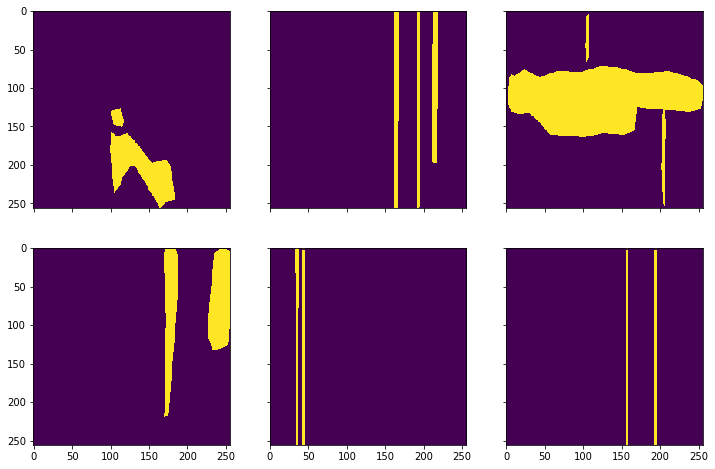

In [46]:
# train_datagen testing
for images, masks in train_datagen(8):
    break
    
print(images.shape, masks.shape)

# show train data generator
nrows = 2
ncols = 3

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,8))
for row in range(nrows):
    for col in range(ncols):
        i = row * ncols + col
        ax[row,col].imshow(images[i])

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,8))
for row in range(nrows):
    for col in range(ncols):
        i = row * ncols + col
        ax[row,col].imshow(np.squeeze(masks[i]))

# 2) Validation Data

In [47]:
# Validation Data (array)

images_val = []
masks_val = []

for i in range(y_val.shape[0]):            
    img = cv2.imread( './input/train_images/'+str(y_val['ImageId'].iloc[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            

    mask = rle2mask(y_val['EncodedPixels'].iloc[i])

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    
    img = img/255.0
    mask = mask/255.0

    images_val += [img]       # x_batch.append(img)
    masks_val += [mask]

images_val = np.array(images_val)
masks_val = np.array(masks_val)
masks_val = np.expand_dims(masks_val, -1)

print('images_val.shape:', images_val.shape)
print('masks_val.shape:', masks_val.shape)

images_val.shape: (710, 256, 256, 3)
masks_val.shape: (710, 256, 256, 1)


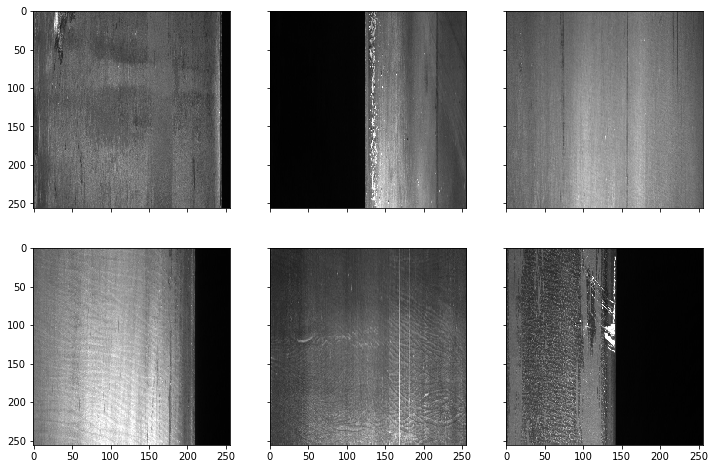

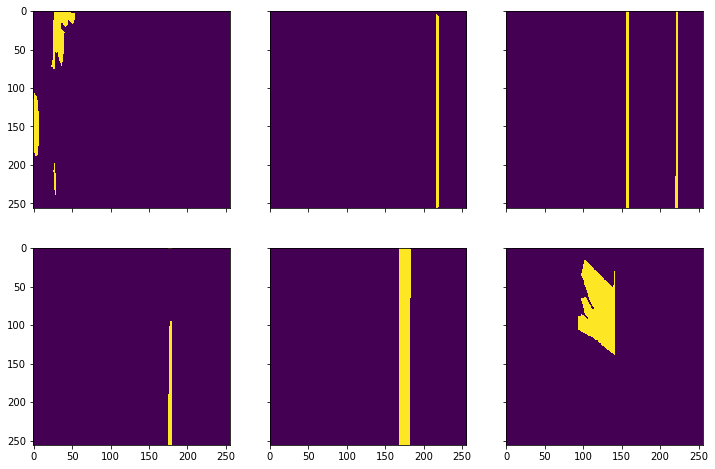

In [48]:
# Show Validation Data
nrows = 2
ncols = 3

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,8))
for row in range(nrows):
    for col in range(ncols):
        i = row * ncols + col
        ax[row,col].imshow(images_val[i])
        
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,8))
for row in range(nrows):
    for col in range(ncols):
        i = row * ncols + col
        ax[row,col].imshow(np.squeeze(masks_val[i]))

# 3) Test Data Generator

In [21]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test1,
    directory='./input/test_images/',
    x_col='ImageId',
    target_size=(256, 256),
    color_mode = 'rgb',
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 1115 validated image filenames.


# Model in Keras

In [20]:
import keras
from keras import backend as K
from keras.layers import Dropout, BatchNormalization, Flatten, Dense, GlobalMaxPooling2D
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, Input, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.applications import DenseNet121, Xception, InceptionResNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import tensorflow as tf

In [21]:
# # Set cpu cores = 1

# from keras import backend as K
# K.set_session(K.tf.Session(config=K.tf.ConfigProto(device_count = {'CPU' : 1, 'GPU': 1},
#                                                    intra_op_parallelism_threads = 4,
#                                                    inter_op_parallelism_threads = 4,
#                                                    )))

In [23]:
# Metric: dice_coef

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [22]:
KEEP_PROB = 0.3

In [24]:
def Create_model():
    
    input_shape = (256,1600,1)
    
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization() (c1)
    c1 = Activation('elu') (c1)
    c1 = Conv2D(8, (3, 3), padding='same') (c1)
    c1 = BatchNormalization() (c1)
    c1 = Activation('elu') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(KEEP_PROB) (p1)

    c2 = Conv2D(16, (3, 3), padding='same') (p1)
    c2 = BatchNormalization() (c2)
    c2 = Activation('elu') (c2)
    c2 = Conv2D(16, (3, 3), padding='same') (c2)
    c2 = BatchNormalization() (c2)
    c2 = Activation('elu') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(KEEP_PROB) (p2)

    c3 = Conv2D(32, (3, 3), padding='same') (p2)
    c3 = BatchNormalization() (c3)
    c3 = Activation('elu') (c3)
    c3 = Conv2D(32, (3, 3), padding='same') (c3)
    c3 = BatchNormalization() (c3)
    c3 = Activation('elu') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(KEEP_PROB) (p3)

    c4 = Conv2D(64, (3, 3), padding='same') (p3)
    c4 = BatchNormalization() (c4)
    c4 = Activation('elu') (c4)
    c4 = Conv2D(64, (3, 3), padding='same') (c4)
    c4 = BatchNormalization() (c4)
    c4 = Activation('elu') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(KEEP_PROB) (p4)

    c5 = Conv2D(64, (3, 3), padding='same') (p4)
    c5 = BatchNormalization() (c5)
    c5 = Activation('elu') (c5)
    c5 = Conv2D(64, (3, 3), padding='same') (c5)
    c5 = BatchNormalization() (c5)
    c5 = Activation('elu') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)
    p5 = Dropout(KEEP_PROB) (p5)

    c55 = Conv2D(128, (3, 3), padding='same') (p5)
    c55 = BatchNormalization() (c55)
    c55 = Activation('elu') (c55)
    c55 = Conv2D(128, (3, 3), padding='same') (c55)
    c55 = BatchNormalization() (c55)
    c55 = Activation('elu') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    model.summary()
    
    return model

In [25]:
def Load_model():
    keras.backend.clear_session()
    
    model = load_model('./model/step2_unet.h5')
    #model.layers[0].trainable = False

    model.compile(
            loss = 'binary_crossentropy',
            optimizer = 'Adam',
            metrics = [dice_coef])
    
    model.summary()
    
    return model

In [26]:
%%time
# Create model
model = Create_model()

# Load model
# model = Load_model()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 1600, 8) 32          conv2d_1[0][0]                   
__________________________________________________________________________________________

In [27]:
# Define callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
# ModelCheckpoint: Save the (best) model weights after every epoch

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
             #EarlyStopping(monitor='val_loss', patience=8, min_delta=1e-4),
             #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, min_lr=1e-6),
             ModelCheckpoint(filepath='./model/step2_unet.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=False)
            ]

In [28]:
EPOCHS = 1

# train_steps = int(np.ceil(y_train.shape[0] / BATCH_SIZE))
# validation_steps = int(np.ceil(y_val.shape[0] / BATCH_SIZE))
# print('train_steps:', train_steps)                         # len(train_generator)
# print('validation_steps:', validation_steps)               # len(validation_generator)

train_steps: 799
validation_steps: 89


In [41]:
%%time
# Train the model

history = model.fit_generator(
                train_datagen,
                #steps_per_epoch = train_steps,
                epochs = EPOCHS,
                #validation_data = val_datagen,
                #validation_steps = validation_steps,
                callbacks = callbacks,
                #workers=1,
                #max_queue_size=10
                )

Epoch 1/1
 54/799 [=>............................] - ETA: 5:52 - loss: 0.0418 - dice_coef: 0.2938

KeyboardInterrupt: 

In [27]:
# Save model
model.save('./model/unet_BN_DO_noval_acc_0.9800.h5')

In [31]:
print(history.history.keys())

dict_keys(['loss', 'dice_coef'])


# Model Evaluation

## Plot Learning rate

learning rate: [0.001, 0.001, 0.001, 0.001, 0.0005, 0.0005, 0.0005, 0.00025, 0.00025, 0.000125, 0.000125, 6.25e-05, 6.25e-05]


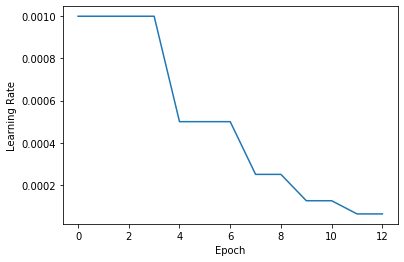

In [37]:
print('learning rate:', history.history['lr'])
plt.plot(history.history['lr'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

## 1) Plot loss and accuracy (train, val)

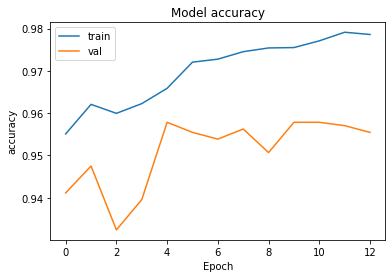

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.show()

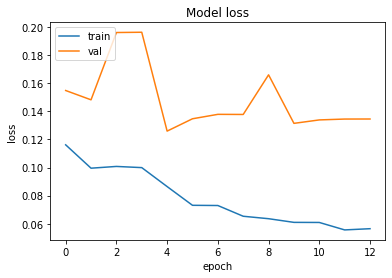

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 2) Loss and accuracy (val)

In [40]:
%%time

validation_generator.reset()
# score = model.evaluate(x_val, y_val)
score = model.evaluate_generator(validation_generator, steps = validation_steps)
print("loss:", score[0])
print("metric (accuracy): ", score[1])

loss: 0.13459698913741913
metric (accuracy):  0.9554494828957836
Wall time: 9.73 s


## 3) ROC AUC (val)

In [41]:
df_val = y_val
df_val.head()

,ImageId,defect
7313,94947e1f9.jpg,True
2119,2aeb8dbd6.jpg,False
8214,a6ecee828.jpg,True
357,07edbd095.jpg,False
5527,6fc6a0964.jpg,True


In [42]:
validation_generator.classes[:5]

[1, 0, 1, 0, 1]

In [43]:
validation_generator.filenames[:5]

['94947e1f9.jpg',
 '2aeb8dbd6.jpg',
 'a6ecee828.jpg',
 '07edbd095.jpg',
 '6fc6a0964.jpg']

In [49]:
%%time

validation_generator.reset()
# y_val_pred = model.predict_classes(x_val)
y_val_pred_prob = model.predict_generator(validation_generator, steps = validation_steps)

Wall time: 9.78 s


In [50]:
print('y_val_pred_prob.shape:', y_val_pred_prob.shape)
y_val_pred_prob

y_val_pred_prob.shape: (1257, 1)


array([[9.9999642e-01],
       [5.5263638e-03],
       [9.9675345e-01],
       ...,
       [3.9896369e-04],
       [9.9999344e-01],
       [9.3592912e-01]], dtype=float32)

In [51]:
y_val_pred = y_val_pred_prob > 0.5
y_val_pred

array([[ True],
       [False],
       [ True],
       ...,
       [False],
       [ True],
       [ True]])

In [52]:
y_val = np.array(validation_generator.classes)
print('y_val.shape:', y_val.shape)
y_val

y_val.shape: (1257,)


array([1, 0, 1, ..., 0, 1, 1])

In [53]:
from sklearn.metrics import roc_auc_score

print('ROC AUC (val): {0}'.format(roc_auc_score(y_val, y_val_pred)))

ROC AUC (val): 0.9554173397679266


## 4) Error Distribution

In [54]:
uniqueValues, occurCount = np.unique(y_val_pred, return_counts=True)

uniqueValues[0], uniqueValues[1] = uniqueValues[1], uniqueValues[0]     #reorder
occurCount[0], occurCount[1] = occurCount[1], occurCount[0]

print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [ True False]
Occurrence Count :  [675 582]


True/False Ratio: 1.159794


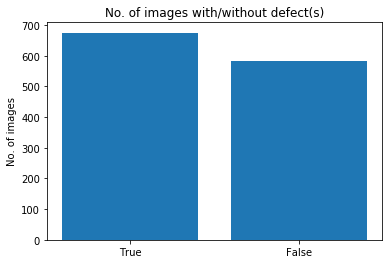

In [55]:
plt.bar(x = (str(uniqueValues[0]), str(uniqueValues[1])), height = occurCount)
plt.title("No. of images with/without defect(s)")
plt.ylabel("No. of images")
print('True/False Ratio: {:f}'.format(occurCount[0]/occurCount[1]))

## 5) Plot confusion matrix (val)

In [56]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, vmax=None, normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    print('confusion_matrix:\n', matrix)
    
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    fig = sns.heatmap(matrix, vmax=vmax, annot=True, square=True,
                cmap=plt.cm.Blues_r, cbar=False, linecolor='black', linewidths=1,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(title)
    plt.show(fig)

confusion_matrix:
 [[552  26]
 [ 30 649]]


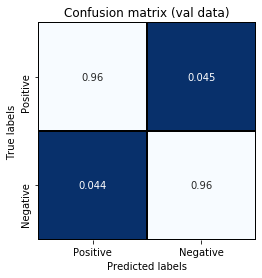

In [57]:
plot_confusion_matrix(y_val, y_val_pred,
                      class_names=['Positive', 'Negative'],
                      title='Confusion matrix (val data)')

## 6) Plot errors

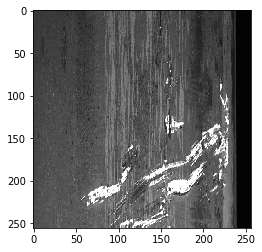

In [58]:
# image from validation_generator
validation_generator[38][0][31].shape   #1st[]: [0:39] no. of batch    2nd[]: [0/1] x/y    3nd[]: [0:32] no. of image in a batch
plt.imshow(validation_generator[38][0][31])

In [59]:
# last batch (40th): 9 images
validation_generator[39][0].shape

(9, 256, 256, 3)

In [60]:
# 1 batch = 32 images
validation_generator[0][0][:].shape

(32, 256, 256, 3)

In [61]:
%%time
x_val = np.concatenate([validation_generator[batch][0][:] for batch in range(len(validation_generator))])   # from 0 to 39
print('x_val.shape:', x_val.shape)

x_val.shape: (1257, 256, 256, 3)
Wall time: 10.1 s


Total no. of error in val set: 56
First 6 error index: [ 7 14 49 56 61 72]


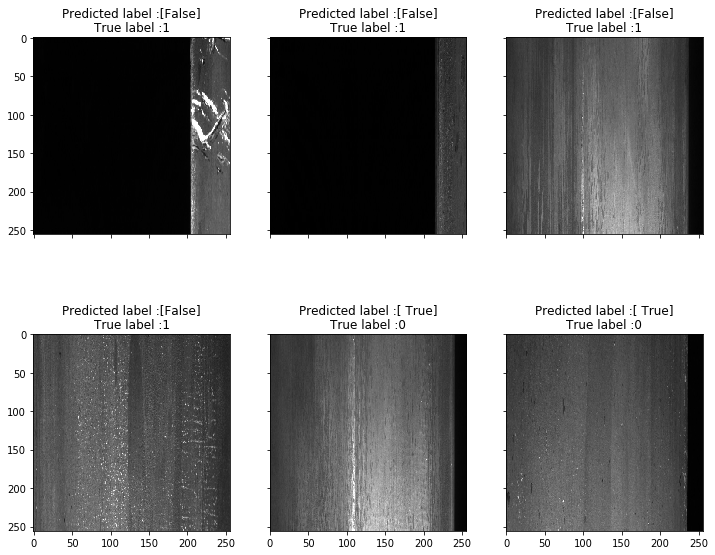

In [62]:
errors = (np.squeeze(y_val_pred) - y_val != 0) # array of bools with true when there is an error or false when the image is cor

index = np.squeeze(np.where(errors==True))
print('Total no. of error in val set:', len(index))
print('First 6 error index:', index[:6])

y_val_pred_er = y_val_pred[errors]
y_val_er = y_val[errors]
x_val_er = x_val[errors]

def display_errors():
    """ This function shows 6 images with their predicted and real labels"""
    nrows = 2
    ncols = 3
    
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,10))
    for row in range(nrows):
        for col in range(ncols):
            i = row * ncols + col
            
            ax[row,col].imshow(x_val_er[i], )
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(y_val_pred_er[i], y_val_er[i]))

# Show the 6 errors
display_errors()

# Prediction

In [73]:
test_steps = int(np.ceil(sample_submission.shape[0] / BATCH_SIZE))           # no. of test_images / batch size
print('test_steps:', test_steps)                                             # len(test_generator)

test_steps: 57


In [74]:
%%time

test_generator.reset()
y_pred_prob = model.predict_generator(test_generator, steps = test_steps)

Wall time: 12.8 s


In [75]:
print('y_pred_prob.shape:', y_pred_prob.shape)
y_pred_prob

y_pred_prob.shape: (1801, 1)


array([[0.82347405],
       [0.7372708 ],
       [0.14082676],
       ...,
       [0.99832964],
       [0.00101423],
       [0.9997396 ]], dtype=float32)

In [76]:
y_pred = y_pred_prob > 0.5
y_pred

array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [ True]])

# Sample_submission
    sample_submission['defect'] = y_pred

In [77]:
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (1801, 2)


,ImageId,defect
0,004f40c73.jpg,True
1,006f39c41.jpg,True
2,00b7fb703.jpg,False
3,00bbcd9af.jpg,True
4,0108ce457.jpg,False


In [78]:
sample_submission['defect'] = y_pred

In [79]:
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (1801, 2)


,ImageId,defect
0,004f40c73.jpg,True
1,006f39c41.jpg,True
2,00b7fb703.jpg,False
3,00bbcd9af.jpg,True
4,0108ce457.jpg,False


In [80]:
sample_submission.isnull().sum()

ImageId    0
defect     0
dtype: int64

True     1115
False     686
Name: defect, dtype: int64
True/False Ratio: 1.625364


Text(0, 0.5, 'No. of images')

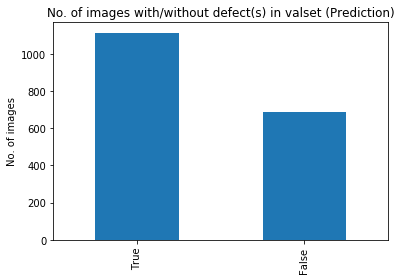

In [83]:
print(sample_submission['defect'].value_counts())
print('True/False Ratio: {:f}'.
      format(sample_submission['defect'].value_counts()[1]/sample_submission['defect'].value_counts()[0]))

sample_submission['defect'].value_counts().plot(kind='bar')
plt.title("No. of images with/without defect(s) in valset (Prediction)")
plt.ylabel("No. of images")

In [72]:
sample_submission.to_csv('./output/submission_step2.csv', index=False)

# Plot Model png

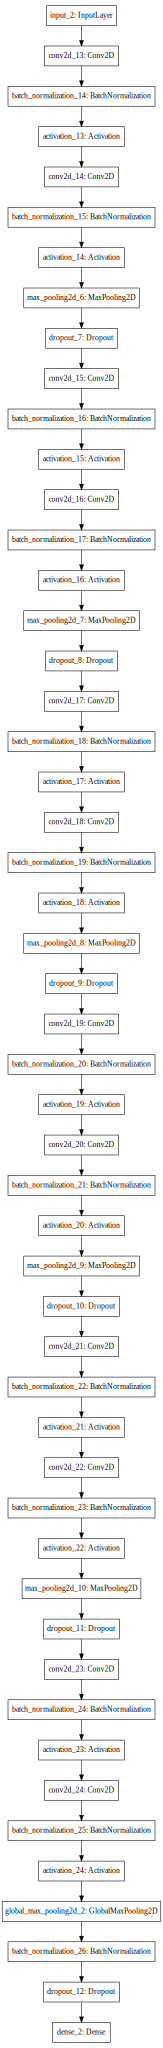

In [66]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='./output/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))